# Exploratory Data Analysis

This Notebook is dedicated to performing the data analysis of the variables that describe the dataset. This notebook will perform data exploration, as well feature engineering using the known physics related to the problem at hand.

In [1]:
#For development
#Reload the library when a change is detected in one of the imported libraries
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [3]:
#Custom utils file
from src import feature_engineering as fe

In [4]:
#Load the RAW dataset
df_b = pd.read_csv('data/wrong/Dataset.csv')
df_b.head()

,Author,P,T,Type of liquid,Type of Gas,DenL,DenG,VisL,VisG,ST,ID,Roughness,Ang,L/D,Vsl,Vsg,Flow_label
0,1985_Piu,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.00007,0.07,0.0254,0,0.0,NaN,0.044817,0.814024,SW
1,1985_Piu,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.00007,0.07,0.0254,0,0.0,600.0,0.060976,0.814024,I
2,1985_Piu,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.00007,0.07,0.0254,0,0.0,600.0,0.088110,0.814024,I
3,1985_Piu,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.00007,0.07,0.0254,0,0.0,600.0,0.060976,1.103659,I
4,1985_Piu,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.00007,0.07,0.0254,0,0.0,600.0,0.121951,1.103659,I


In [5]:
df_b = shuffle(df_b, random_state=0)
df_b.reset_index(drop=True, inplace=True)
df_b.head()

,Author,P,T,Type of liquid,Type of Gas,DenL,DenG,VisL,VisG,ST,ID,Roughness,Ang,L/D,Vsl,Vsg,Flow_label
0,1982_Ova,102973.3,NaN,water,Air,1000.0,1.8,0.001,0.000015,0.07,0.025,0,-10.0,NaN,0.004000,0.100000,SW
1,1982_Ova,103792.3,NaN,water,Air,1000.0,1.8,0.001,0.000015,0.07,0.051,0,70.0,NaN,1.576270,6.288810,I
2,1982_Ova,102647.3,NaN,water,Air,1000.0,1.8,0.001,0.000015,0.07,0.051,0,15.0,NaN,1.048110,0.151886,I
3,1982_Ova,102812.3,NaN,water,Air,1000.0,1.8,0.001,0.000015,0.07,0.051,0,20.0,NaN,0.096738,1.592980,I
4,1982_Ova,103924.3,NaN,water,Air,1000.0,1.8,0.001,0.000015,0.07,0.025,0,-80.0,NaN,0.004077,16.383900,SW


Define features and target columns

In [6]:
target = 'Flow_label'
features_b = df_b.columns.drop(target) #Bronze features

## Train Test Splitting

The first and most important part of the analysis, to avoid information leakage (and hence optimistic expectations) is to split the data between training and testing. Since we are dealing with a classification problem, stratified k fold is applied to the labels in order to preserve the original distribution in both training and testing

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #SKF
train_idx, test_idx = next(skf.split(df_b[features_b].values, df_b[target].values.ravel())) #Get the split
df_b_train, df_b_test = df_b.loc[train_idx].reset_index(drop=True), df_b.loc[test_idx] #Train, Test

We now save the bronze (unprocessed) data in the right folder. No reasonable infomration leakage can now happen between training and testing now

## Null Values and Variables Distribution

We can now properly analyze the data, fist by checking for missing values, and then by exploring variables distributions

In [8]:
Null_values = df_b.isnull().mean()[df_b.isnull().mean()!=0]
Null_values

P      0.009044
T      0.650690
L/D    0.716934
dtype: float64

It is clear that most of the data related to the lenght of the pipe is missing. While some argument could be made about treating this variable as a categorical and mean encode it, to keep the model relaviely simple, it will be removed in the following step (in the tranformation of the data from bronze to silver)

## Target Distribution

We see that the data is far from being evenly distribuited. The next step is to assess weather the target is balanced or not

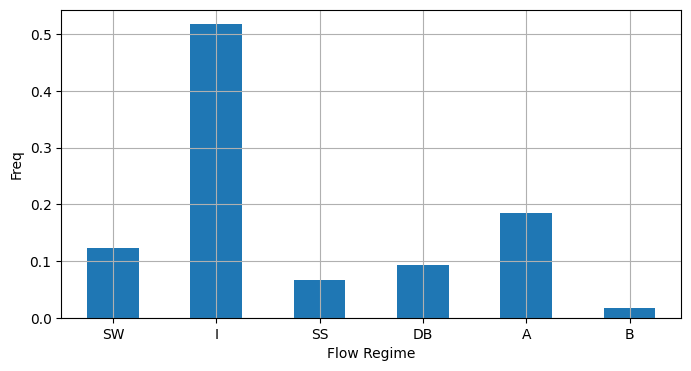

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))   

out_norm = df_b[target].value_counts(sort=False, normalize=True).mul(1)
out_norm.plot.bar(rot=0)
axes.set_ylabel("Freq")
axes.set_xlabel("Flow Regime")
axes.grid()

plt.show()
fig.savefig(f'plots/others/flow_patterns.png', dpi=fig.dpi, bbox_inches='tight')

There is a strong imbalance between the labels, the intermittent flow regime cover more than half the data. During training, oversampling technqiues will be required to improve the detection of the minority classes

## Feature Engineering

Once we have analyzed the various distribution, we see that feature engineering will be required to better separate the various classes. This is fundamental in tree based models like RandomForest and LightGBM. Additionally, to improve generability (sacrificng performance on this specific dataset) dimensionless quantities will replace dimensional quantities previously analyzed

In [10]:
df_g = fe.bronze_to_gold(df_b) #Gold data (Ready to be processed)
features_g = df_g.columns.drop(target) #Gold features
df_g.head()

,Ang,ReL,ReG,FrL,FrG,NL,X_LM,X_LM_2,Y,We,Eo,HU,K_G,T_TB,Flow_label
0,-10.0,100.0000,300.00000,0.008086,0.008576,0.003234,1.632993,2.666667,-22133.355066,0.005714,87.401768,0.049310,0.085762,0.000021,3
1,70.0,80389.7700,38487.51720,2.230881,0.377616,0.066492,5.446049,29.659449,3151.951310,1810.228325,363.731198,0.776082,107.065836,0.008842,2
2,15.0,53453.6100,929.54232,1.483381,0.009120,0.046218,38.626531,1492.008865,90389.054098,800.360903,363.731198,0.941572,2.108571,0.004272,2
3,20.0,4933.6227,9749.03760,0.136912,0.095652,0.005761,1.572683,2.473331,12743.796628,6.818104,363.731198,0.871029,6.718547,0.000066,2
4,-80.0,101.9275,49151.70000,0.008242,1.405123,0.003265,0.073892,0.005460,-252.151673,0.005937,87.401768,0.024407,14.186005,0.000021,3


## Specific BoxPlots

It can be interesting to display the boxplots of some promising features, to check if they are of use to separate the various classes. Here the three most important features found in the analysis are displayed, and they are clearly able to differentiate the flow regimes by some degree. Note that for display purposes, the logarithm of the velocities is taken (the models used for the analysis are however unaffected by the scale of the features used)

In [11]:
log_q = [q for q in df_g[features_g].columns if df_g[q].min()>=0]
df_log = pd.DataFrame(df_b[target], columns=[target])
for q in log_q:
    df_log[f'log({q})'] = np.log10(df_g[q])

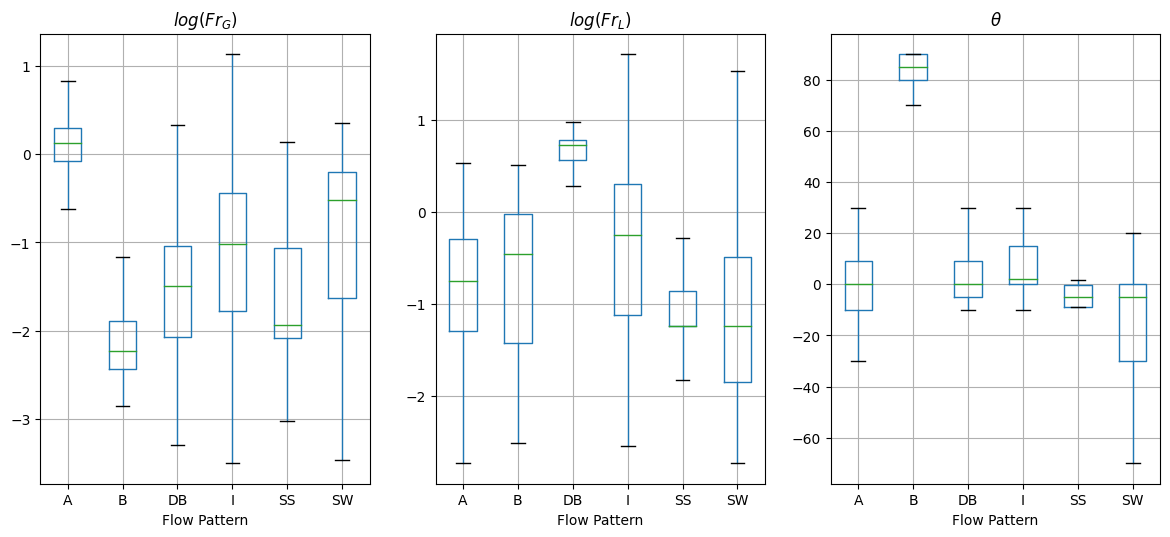

In [12]:
df_ALL = pd.concat([df_log, df_g, df_b], axis=1)
df_ALL = df_ALL.loc[:,~df_ALL.columns.duplicated()]

to_plot_features = ["log(FrG)", "log(FrL)", "Ang"]

fig, axes = plt.subplots(nrows=1, ncols=len(to_plot_features), figsize=(14, 6)) 
for quantity, i in zip(to_plot_features, range(len(to_plot_features))):
    df_ALL[[quantity, target]].boxplot(by=target, 
                                           showfliers=False, 
                                           ax=axes[i])
    axes[i].set_xlabel("Flow Pattern")
    fig.suptitle('')

axes[0].set_title(r"$log(Fr_{G})$")
axes[1].set_title(r"$log(Fr_{L})$")
axes[2].set_title(r"$\theta$")

fig.savefig(f'plots/boxplots/specific_features.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

## Feature Correlation

We can check the quality of the generated features by mean of correlation. It is evident that the proposed features are mostly uncorrelated, and offer different types of signals for our model.

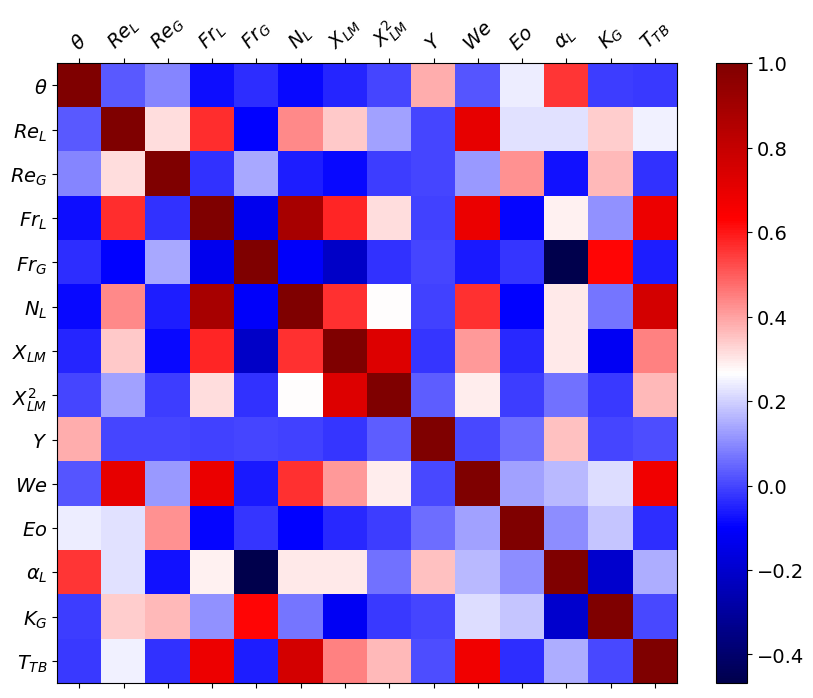

In [13]:
df_corr = df_g.drop(columns=target)
df_corr.columns = [r'$\theta$', r'$Re_{L}$', r'$Re_{G}$', 
                   r'$Fr_{L}$', r'$Fr_{G}$', r'$N_{L}$', 
                   r'$X_{LM}$', r'$X_{LM}^2$', r'$Y$', 
                   r'$We$', r'$Eo$', r'$\alpha_{L}$', 
                   r'$K_{G}$', r'$T_{TB}$']

fig = plt.figure(figsize=(10, 8), dpi=100)
plt.matshow((df_corr).corr(), fignum=fig.number, cmap='seismic')

plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

fig.savefig(f'plots/others/correlation_matrix.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

In [14]:
df_b.to_csv('data/Train_bronze.csv', index=False)
df_b_test.to_csv('data/Test_bronze.csv', index=False)
df_g.to_csv('data/Train_gold.csv', index=False)